In [ ]:
# 1:IMPORT LIBRARIES
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Layer
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from google.colab import files, drive
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import re
from pathlib import Path
import shutil
import json
import io
import sys
import transformers as hf_transformers
import sklearn

# DATA LOADING AND PREPROCESSING
print("\n Loading and Preprocessing Data ")

def clean_text(text: str) -> str:

    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)                 # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)           # Remove non-alphanumeric characters
    text = text.lower()                               # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()          # Remove extra whitespace
    return text

# Upload the dataset zip file
if 'google.colab' in sys.modules:
    uploaded = files.upload()

# Unzip and load the data
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

fake_df = pd.read_csv('/content/data/Fake.csv')
true_df = pd.read_csv('/content/data/True.csv')

# ADDRESSING DATA LEAKAGE
# Many 'True' articles from Reuters start with "CITY (Reuters) - ".
# This flaw allows the model to cheat by simply detecting the word "Reuters".
# We remove this part of the text to force the model to learn from the actual content.
true_df['text'] = true_df['text'].apply(lambda x: x.split(' - ', 1)[-1])

# Add labels: 1 for Fake, 0 for Real
fake_df['label'] = 1
true_df['label'] = 0

# Combine, shuffle, and clean the data
df = pd.concat([fake_df, true_df]).sample(frac=1, random_state=42).reset_index(drop=True)
df['content'] = (df['title'].astype(str) + ' ' + df['text'].astype(str)).apply(clean_text)
df = df[['content', 'label']]

print(f"\nDataset loaded successfully with {len(df)} articles.")
print("Class distribution:\n", df['label'].value_counts())

# Split the data into training (80%), validation (10%), and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    df['content'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nData Split:")
print(f"Training data size:   {len(X_train)}")
print(f"Validation data size: {len(X_val)}")
print(f"Test data size:       {len(X_test)}")


--- Section 0: Installing and Importing Libraries ---

--- Section 1: Loading and Preprocessing Data ---


Saving archive.zip to archive (1).zip

Dataset loaded successfully with 44898 articles.
Class distribution:
 label
1    23481
0    21417
Name: count, dtype: int64

Data Split:
Training data size:   35918
Validation data size: 4490
Test data size:       4490


In [ ]:
# 2: DEFINING THE BERT-CNN MODEL (With Regularization)
print("\n Defining Tokenizer and BERT-CNN Model")

# Model Parameters
MAX_LEN = 128
MODEL_NAME = 'bert-base-uncased'

# 2.1 Load BERT Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def tokenize_data(X, tokenizer, max_len):

    return tokenizer(
        text=list(X), add_special_tokens=True, max_length=max_len,
        truncation=True, padding='max_length', return_tensors='tf',
        return_attention_mask=True, verbose=True
    )

# Custom Keras Layer to be self-contained and serializable
class BertFeatureExtractor(Layer):

    def __init__(self, model_name='bert-base-uncased', **kwargs):
        super(BertFeatureExtractor, self).__init__(**kwargs)
        self.model_name = model_name
        # Create the BERT model inside the layer
        self.bert = TFBertModel.from_pretrained(self.model_name, from_pt=True)
        # We can set the trainability here
        self.bert.trainable = False

    def call(self, inputs):
        # The 'inputs' will be the dictionary {'input_ids': ..., 'attention_mask': ...}
        outputs = self.bert(inputs)
        return outputs.last_hidden_state

    def get_config(self):
        # This method allows Keras to save and reload the layer
        config = super().get_config()
        config.update({
            "model_name": self.model_name,
        })
        return config

# 2.2 Define the BERT-CNN Model Architecture
def create_bert_cnn_model(max_len=MAX_LEN, bert_model_name=MODEL_NAME):

    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # Instantiate our self-contained, serializable layer
    bert_extractor = BertFeatureExtractor(model_name=bert_model_name)

    # Pass the inputs as a dictionary to the layer
    bert_output = bert_extractor({'input_ids': input_ids, 'attention_mask': attention_mask})

    # REGULARIZATION AND CLASSIFICATION HEAD
    cnn_layer = Conv1D(filters=64, kernel_size=3, padding="valid", activation="relu")(bert_output)
    pooling_layer = GlobalMaxPooling1D()(cnn_layer)

    x = Dropout(0.6)(pooling_layer)
    x = Dense(32, activation="tanh")(x)
    x = Dropout(0.6)(x)

    output = Dense(1, activation="sigmoid", name="classification")(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Create the full BERT-CNN model using the function
model = create_bert_cnn_model()

print("\nBERT-CNN Model Architecture:")
model.summary()


--- Section 2: Defining Tokenizer and BERT-CNN Model ---


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already


BERT-CNN Model Architecture:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_feature_extra… │ (None, 128, 768)  │          0 │ attention_mask[0… │
│ (BertFeatureExtrac… │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 126, 64)   │    147,520 │ bert_feature_ext… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │         33 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 149,633 (584.50 KB)

 Trainable params: 149,633 (584.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 3. TRAINING THE MODEL
print("\n Training the Model")

# Tokenize all data splits
print("Tokenizing data...")
X_train_token = tokenize_data(X_train, bert_tokenizer, MAX_LEN)
X_val_token = tokenize_data(X_val, bert_tokenizer, MAX_LEN)
X_test_token = tokenize_data(X_test, bert_tokenizer, MAX_LEN)

# Optimizer and Callbacks
optimizer = Adam(learning_rate=2e-5, epsilon=1e-08)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, verbose=1, min_lr=1e-7)

# Custom callback to stop training if validation accuracy reaches a threshold
class EarlyStoppingByValAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', threshold=0.97):
        super(EarlyStoppingByValAccuracy, self).__init__()
        self.monitor = monitor
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get(self.monitor)
        if current_val_accuracy is not None and current_val_accuracy >= self.threshold:
            print(f"\nEpoch {epoch+1}: Validation accuracy reached {current_val_accuracy:.4f}, which is >= {self.threshold}. Stopping training.")
            self.model.stop_training = True

stop_on_accuracy = EarlyStoppingByValAccuracy(threshold=0.97)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
print("\nStarting model training...")
history = model.fit(
    x={'input_ids': X_train_token['input_ids'], 'attention_mask': X_train_token['attention_mask']},
    y=y_train,
    validation_data=(
        {'input_ids': X_val_token['input_ids'], 'attention_mask': X_val_token['attention_mask']},
        y_val
    ),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, stop_on_accuracy]
)


--- Section 3: Training the Model ---
Tokenizing data...

Starting model training...
Epoch 1/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 311s 261ms/step - accuracy: 0.5147 - loss: 0.9383 - val_accuracy: 0.9236 - val_loss: 0.3758 - learning_rate: 2.0000e-05
Epoch 2/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 298s 245ms/step - accuracy: 0.7163 - loss: 0.5655 - val_accuracy: 0.9452 - val_loss: 0.1855 - learning_rate: 2.0000e-05
Epoch 3/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 275s 245ms/step - accuracy: 0.8727 - loss: 0.3187 - val_accuracy: 0.9586 - val_loss: 0.1382 - learning_rate: 2.0000e-05
Epoch 4/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 333s 254ms/step - accuracy: 0.9133 - loss: 0.2527 - val_accuracy: 0.9650 - val_loss: 0.1082 - learning_rate: 2.0000e-05
Epoch 5/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9331 - loss: 0.2048
Epoch 5: Validation accuracy reached 0.9717, which is >= 0.97. Stopping training.
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 322s 254ms/step - accuracy: 0.9331 - loss: 0.2048 - val_accurac


--- Section 4: Evaluating the Model ---
Plotting model training history...


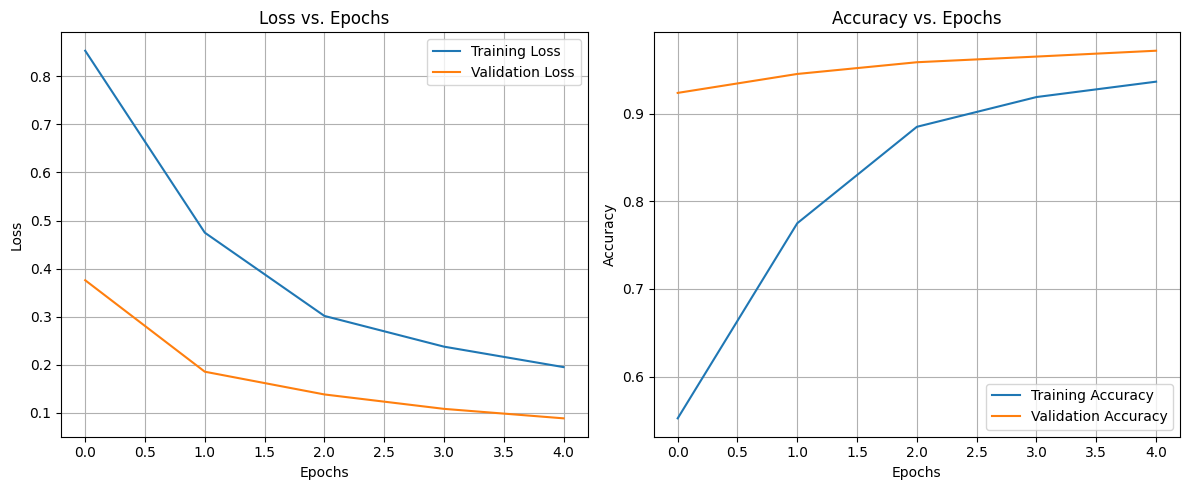


Making predictions on the test set...
141/141 ━━━━━━━━━━━━━━━━━━━━ 31s 219ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

    Real (0)       0.97      0.96      0.96      2142
    Fake (1)       0.96      0.98      0.97      2348

    accuracy                           0.97      4490
   macro avg       0.97      0.97      0.97      4490
weighted avg       0.97      0.97      0.97      4490


Confusion Matrix:


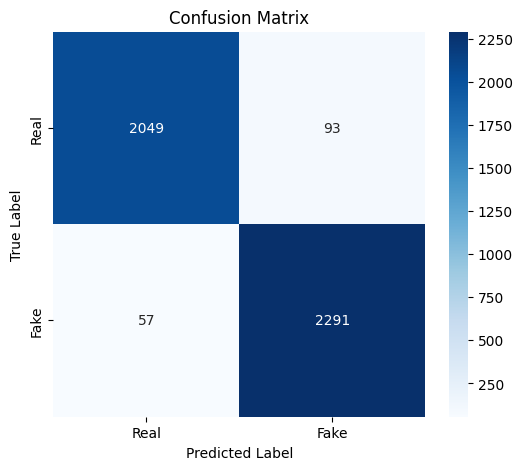

In [ ]:
# 4: EVALUATING THE MODEL
print("\n Evaluating the Model")

# Accept 'save_path' to save the figure to a file.
def plot_training_history(history, save_path=None):

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    # Logic to either save or show the plot
    if save_path:
        plt.savefig(save_path)
        plt.close()  # Close the plot to prevent it from displaying twice
    else:
        plt.show()

# First, display the plot in the notebook as before
print("Plotting model training history...")
plot_training_history(history)

# Make predictions on the unseen test set
print("\nMaking predictions on the test set...")
predicted_probabilities = model.predict({
    'input_ids': X_test_token['input_ids'],
    'attention_mask': X_test_token['attention_mask']
})
binary_predictions = (predicted_probabilities > 0.5).astype(int)

# Generate and print the classification report. Store it in a variable for later saving.
print("\nClassification Report on Test Set:")
report = classification_report(y_test, binary_predictions, target_names=['Real (0)', 'Fake (1)'])
print(report)

# Accept 'save_path' to save the figure to a file.
def plot_confusion_matrix(y_true, y_pred, save_path=None):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    # Logic to either save or show the plot
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

# First, display the confusion matrix in the notebook
print("\nConfusion Matrix:")
plot_confusion_matrix(y_test, binary_predictions)

In [ ]:
# 5: SAVE FINAL ARTIFACTS TO GOOGLE DRIVE
print("\n Saving Final Artifacts to Google Drive")

try:
    # Mount Google Drive. force_remount=True avoids errors if it's already mounted.
    print("Mounting Google Drive...")
    from google.colab import drive
    import datetime
    drive.mount('/content/drive', force_remount=True)

    # Create a unique subfolder for this run using a timestamp
    run_timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    run_dir = f'/content/drive/MyDrive/fake_news_artifacts/run_{run_timestamp}'
    os.makedirs(run_dir, exist_ok=True)
    print(f"Artifacts for this run will be saved to: {run_dir}")

    # Define full paths for all artifacts
    model_weights_path = os.path.join(run_dir, "final_model.weights.h5")
    tokenizer_path = os.path.join(run_dir, "tokenizer")
    history_plot_path = os.path.join(run_dir, "final_training_history.png")
    report_path = os.path.join(run_dir, "classification_report.txt")
    cm_plot_path = os.path.join(run_dir, "confusion_matrix.png")

    # 1. Save the model's final (best) weights
    model.save_weights(model_weights_path)
    print(f"-> Model weights saved successfully to {model_weights_path}")

    # 2. Save the tokenizer
    bert_tokenizer.save_pretrained(tokenizer_path)
    print(f"-> Tokenizer saved successfully to {tokenizer_path}")

    # 3. Save the training history plot by calling the corrected function
    plot_training_history(history, save_path=history_plot_path)
    print(f"-> Training history plot saved successfully to {history_plot_path}")

    # 4. Save the classification report to a text file
    with open(report_path, 'w') as f:
        f.write("Classification Report on the Test Set\n")
        f.write("="*40 + "\n")
        f.write(report)
    print(f"-> Classification report saved successfully to {report_path}")

    # 5. Save the confusion matrix plot by calling the corrected function
    plot_confusion_matrix(y_test, binary_predictions, save_path=cm_plot_path)
    print(f"-> Confusion matrix plot saved successfully to {cm_plot_path}")

except Exception as e:
    print(f"\nAN ERROR OCCURRED: Could not save artifacts to Google Drive.")
    print(f"Error details: {e}")


--- Section 5: Saving Final Artifacts to Google Drive ---
Mounting Google Drive...
Mounted at /content/drive
Artifacts for this run will be saved to: /content/drive/MyDrive/fake_news_artifacts/run_20250919-080632
-> Model weights saved successfully to /content/drive/MyDrive/fake_news_artifacts/run_20250919-080632/final_model.weights.h5
-> Tokenizer saved successfully to /content/drive/MyDrive/fake_news_artifacts/run_20250919-080632/tokenizer
-> Training history plot saved successfully to /content/drive/MyDrive/fake_news_artifacts/run_20250919-080632/final_training_history.png
-> Classification report saved successfully to /content/drive/MyDrive/fake_news_artifacts/run_20250919-080632/classification_report.txt
-> Confusion matrix plot saved successfully to /content/drive/MyDrive/fake_news_artifacts/run_20250919-080632/confusion_matrix.png


In [ ]:
# 6: DEPLOYING WITH GRADIO
import gradio as gr
import tensorflow as tf
import re
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Layer
from pathlib import Path
import os

# 1: DYNAMICALLY FIND LATEST RUN AND LOAD ARTIFACTS

# Base directory for all saved runs
BASE_ARTIFACTS_DIR = Path("/content/drive/MyDrive/fake_news_artifacts")

# Find all run directories and get the most recent one by name
try:
    all_runs = sorted([d for d in BASE_ARTIFACTS_DIR.iterdir() if d.is_dir() and d.name.startswith('run_')])
    LATEST_DIR = all_runs[-1]
    print(f"Found latest run directory: {LATEST_DIR}")
except (IndexError, FileNotFoundError):
    print("ERROR: Could not find any run directories in '/content/drive/MyDrive/fake_news_artifacts'. Please run the training section first.")
    # Stop execution if no model is found
    LATEST_DIR = None

if LATEST_DIR:
    print("Loading tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(LATEST_DIR / "tokenizer")
    WEIGHTS_PATH = LATEST_DIR / "final_model.weights.h5"

#  2: DEFINE THE EXACT CUSTOM LAYER AND MODEL STRUCTURE
class BertFeatureExtractor(Layer):
    """A custom Keras layer to extract BERT features, matching the one used in training."""
    def __init__(self, model_name='bert-base-uncased', **kwargs):
        super(BertFeatureExtractor, self).__init__(**kwargs)
        self.model_name = model_name
        self.bert = TFBertModel.from_pretrained(self.model_name, from_pt=True)
        self.bert.trainable = False

    def call(self, inputs):
        return self.bert(inputs).last_hidden_state

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": self.model_name})
        return config

def create_bert_cnn_model(max_len=128):
    """Re-creates the exact BERT-CNN model architecture."""
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    bert_output = BertFeatureExtractor(model_name='bert-base-uncased')({'input_ids': input_ids, 'attention_mask': attention_mask})
    cnn = Conv1D(filters=64, kernel_size=3, padding="valid", activation="relu")(bert_output)
    pool = GlobalMaxPooling1D()(cnn)
    x = Dropout(0.6)(pool)
    x = Dense(32, activation="tanh")(x)
    x = Dropout(0.6)(x)
    output = Dense(1, activation="sigmoid", name="classification")(x)
    return Model(inputs=[input_ids, attention_mask], outputs=output)

#  3: RE-CREATE MODEL AND LOAD THE WEIGHTS
if LATEST_DIR:
    print("Re-creating the BERT-CNN model structure...")
    deployment_model = create_bert_cnn_model()

    print(f"Loading weights from: {WEIGHTS_PATH}")
    deployment_model.load_weights(WEIGHTS_PATH)

    print("\nModel and tokenizer loaded successfully.")
    deployment_model.summary()

#  4: DEFINE PREDICTION AND CLEANING FUNCTIONS
def clean_text_for_prediction(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def predict_fake_news(text):
    if not LATEST_DIR or not hasattr(deployment_model, 'predict'):
        return {"ERROR": 1.0, "Model not loaded": 0.0}

    # 1. Clean and tokenize the input text
    cleaned_text = clean_text_for_prediction(text)
    inputs = tokenizer(cleaned_text, add_special_tokens=True, max_length=128, truncation=True,
                       padding='max_length', return_tensors='tf')

    # 2. Get prediction from the model
    prediction_score = deployment_model.predict({
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    }, verbose=0)[0][0]

    # 3. Format the output for Gradio's Label component
    fake_prob = float(prediction_score)
    real_prob = 1 - fake_prob
    return {'FAKE': fake_prob, 'REAL': real_prob}

#  5: LAUNCH THE GRADIO INTERFACE
examples = [
    ["BREAKING: A source close to the White House claims the president is secretly a lizard person. The evidence is undeniable, experts say."],
    ["The S&P 500 closed up 0.5% on Tuesday after the Federal Reserve announced it would hold interest rates steady, citing stable inflation figures."],
    ["You will be SHOCKED to learn about this one weird trick to lose weight. Doctors don't want you to know this simple secret."]
]

interface = gr.Interface(
    fn=predict_fake_news,
    inputs=gr.Textbox(lines=8, placeholder="Paste a news article, headline, or text snippet here..."),
    outputs=gr.Label(num_top_classes=2, label="Verdict"),
    title=" BERT-CNN Fake News Detector",
    description="This interface uses a fine-tuned BERT model combined with a CNN to classify text as REAL or FAKE. Paste an article below and see the model's prediction.",
    examples=examples,
    allow_flagging="never" # Disables the flagging button for a cleaner interface
)

if LATEST_DIR:
    interface.launch(debug=True, share=True)
else:
    print("\nCould not launch Gradio interface because the model and tokenizer failed to load.")


--- Section 6: Building the Gradio Web Interface ---
Found latest run directory: /content/drive/MyDrive/fake_news_artifacts/run_20250919-080632
Loading tokenizer...
Re-creating the BERT-CNN model structure...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Loading weights from: /content/drive/MyDrive/fake_news_artifacts/run_20250919-080632/final_model.weights.h5

Model and tokenizer loaded successfully.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_feature_extra… │ (None, 128, 768)  │          0 │ attention_mask[0… │
│ (BertFeatureExtrac… │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 126, 64)   │    147,520 │ bert_feature_ext… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │         33 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 149,633 (584.50 KB)

 Trainable params: 149,633 (584.50 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:414: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e13c75995e52b21452.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e13c75995e52b21452.gradio.live
